In [ ]:
# In this Jupyter I built a Q-Learning Model to optimize the value of a portfolio
# The state is [stock, price of stock, initial investment]
# Action is 0: sell ,1=hold, 2: sell
# reward is the increase in porfolio value

#I trained 3 stock in a portfolio AAPL, MSI and SBUX 
#The graph of rewards has been ploted at the end

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import itertools
import argparse
import re
import os
import pickle
import codecs

from sklearn.preprocessing import StandardScaler

In [2]:
def get_data():
    
  # returns a T x 3 list of stock prices
  # each row is a different stock
  # 0 = AAPL
  # 1 = MSI
  # 2 = SBUX
    df = pd.read_csv('/Users/naghmeh/Documents/Quant/ipython,RL/B1.csv',skip_blank_lines=True).dropna()
    return df.values

In [3]:
def get_scaler(env):
  # return scikit-learn scaler object to scale the states
  # Note: you could also populate the replay buffer here

    states = []
    for _ in range(env.n_step):
        action = np.random.choice(env.action_space)
        state, reward, done, info = env.step(action)
        states.append(state)
        if done:
            break

    scaler = StandardScaler()
    scaler.fit(states)
    return scaler

In [4]:
class LinearModel:
    def __init__(self, input_dim, n_action):
        
        self.W = np.random.randn(input_dim, n_action) / np.sqrt(input_dim)
        self.b = np.zeros(n_action)

    # momentum terms
        self.vW = 0
        self.vb = 0

        self.losses = []

    def predict(self, X):
    # make sure X is N x D
        assert(len(X.shape) == 2)
        return X.dot(self.W) + self.b

    def sgd(self, X, Y, learning_rate=0.01, momentum=0.9):
    # make sure X is N x D
        assert(len(X.shape) == 2)

    # the loss values are 2-D
    # normally we would divide by N only
    # but now we divide by N x K
        num_values = np.prod(Y.shape)

        Yhat = self.predict(X)
        gW = 2 * X.T.dot(Yhat - Y) / num_values
        gb = 2 * (Yhat - Y).sum(axis=0) / num_values

    # update momentum terms
        self.vW = momentum * self.vW - learning_rate * gW
        self.vb = momentum * self.vb - learning_rate * gb

    # update params
        self.W += self.vW
        self.b += self.vb

        mse = np.mean((Yhat - Y)**2)
        self.losses.append(mse)
       






In [5]:
class MultiStockEnv:

    def __init__(self, data, initial_investment=20000):
    # data
        self.stock_price_history = data
        self.n_step, self.n_stock = self.stock_price_history.shape

    # instance attributes
        self.initial_investment = initial_investment
        self.cur_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None

        self.action_space = np.arange(3**self.n_stock)

    # action permutations
    # returns a nested list with elements like:
    # [0,0,0]
    # [0,0,1]
    # [0,0,2]
    # [0,1,0]
    # [0,1,1]
    # etc.
    # 0 = sell
    # 1 = hold
    # 2 = buy
        self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

    # calculate size of state
        self.state_dim = self.n_stock * 2 + 1

        self.reset()


    def reset(self):
        self.cur_step = 0
        self.stock_owned = np.zeros(self.n_stock)
        self.stock_price = self.stock_price_history[self.cur_step]
        self.cash_in_hand = self.initial_investment
        return self._get_obs()


    def step(self, action):
        assert action in self.action_space

    # get current value before performing the action
        prev_val = self._get_val()

    # update price, i.e. go to the next day
        self.cur_step += 1
        self.stock_price = self.stock_price_history[self.cur_step]

    # perform the trade
        self._trade(action)

    # get the new value after taking the action
        cur_val = self._get_val()

    # reward is the increase in porfolio value
        reward = cur_val - prev_val

    # done if we have run out of data
        done = self.cur_step == self.n_step - 1

    # store the current value of the portfolio here
        info = {'cur_val': cur_val}

    # conform to the Gym API
        return self._get_obs(), reward, done, info


    def _get_obs(self):
        obs = np.empty(self.state_dim)
        obs[:self.n_stock] = self.stock_owned
        obs[self.n_stock:2*self.n_stock] = self.stock_price
        obs[-1] = self.cash_in_hand
        return obs
    


    def _get_val(self):
        return self.stock_owned.dot(self.stock_price) + self.cash_in_hand


    def _trade(self, action):
    # index the action we want to perform
    # 0 = sell
    # 1 = hold
    # 2 = buy
    # e.g. [2,1,0] means:
    # buy first stock
    # hold second stock
    # sell third stock
        action_vec = self.action_list[action]

    # determine which stocks to buy or sell
        sell_index = [] # stores index of stocks we want to sell
        buy_index = [] # stores index of stocks we want to buy
        PortAction=[]
        for i, a in enumerate(action_vec):
            if a == 0:
                sell_index.append(i)
                PortAction.append('Sell')
            elif a == 2:
                buy_index.append(i)
                PortAction.append('Buy')
            elif a==1:
                PortAction.append('Hold')
            

    # sell any stocks we want to sell
    # then buy any stocks we want to buy
        if sell_index:
            for i in sell_index:
                self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
                self.stock_owned[i] = 0
        if buy_index:
            can_buy = True
            while can_buy:
                for i in buy_index:
                    if self.cash_in_hand > self.stock_price[i]:
                        self.stock_owned[i] += 1 # buy one share
                        self.cash_in_hand -= self.stock_price[i]
                    else:
                        can_buy = False
                    
        return PortAction            






In [6]:
class DQNAgent(object):
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = LinearModel(state_size, action_size)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action


    def train(self, state, action, reward, next_state, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.amax(self.model.predict(next_state), axis=1)

        target_full = self.model.predict(state)
        target_full[0, action] = target

    # Run one training step
        self.model.sgd(state, target_full)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    def load(self, name):
        self.model.load_weights(name)


    def save(self, name):
        self.model.save_weights(name)


def play_one_episode(agent, env):
  # note: after transforming states are already 1xD
    state = env.reset()
    state = scaler.transform([state])
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        agent.train(state, action, reward, next_state, done)
        state = next_state

    return info['cur_val'],action, reward

In [7]:
if __name__ == '__main__':
    

  # config
    models_folder = 'linear_rl_trader_models'
    rewards_folder = 'linear_rl_trader_rewards'
    num_episodes = 2000
    batch_size = 32
    initial_investment = 20000

    data = get_data()
    n_timesteps, n_stocks = data.shape

    n_train = n_timesteps // 2

    train_data = data[:n_train]
    test_data = data[n_train:]

    env = MultiStockEnv(train_data, initial_investment)
    state_size = env.state_dim
    action_size = len(env.action_space)
    agent = DQNAgent(state_size, action_size)
    scaler = get_scaler(env)



In [8]:
portfolio_value = []
agent.epsilon = 0.01
Reward_train=[]
for e in range(num_episodes):
    t0 = datetime.now()
    val,action,reward = play_one_episode(agent, env)
    dt = datetime.now() - t0
    print(f"episode: {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt} Action: {env._trade(action)} Rewards: {reward}", )
    portfolio_value.append(val) # append episode end portfolio value
    Reward_train.append(reward)

episode: 1/2000, episode end value: 33152.96, duration: 0:00:00.137044 Action: ['Hold', 'Hold', 'Hold'] Rewards: 107.43000000000029
episode: 2/2000, episode end value: 38958.60, duration: 0:00:00.119688 Action: ['Sell', 'Buy', 'Buy'] Rewards: -20.429999999993015
episode: 3/2000, episode end value: 29173.05, duration: 0:00:00.127017 Action: ['Sell', 'Buy', 'Buy'] Rewards: -15.299999999999272
episode: 4/2000, episode end value: 28790.50, duration: 0:00:00.126150 Action: ['Sell', 'Buy', 'Buy'] Rewards: -15.089999999996508
episode: 5/2000, episode end value: 46978.33, duration: 0:00:00.119837 Action: ['Sell', 'Buy', 'Buy'] Rewards: 139.3199999999997
episode: 6/2000, episode end value: 23323.03, duration: 0:00:00.118858 Action: ['Sell', 'Buy', 'Buy'] Rewards: 141.5699999999997
episode: 7/2000, episode end value: 31177.83, duration: 0:00:00.113189 Action: ['Sell', 'Buy', 'Buy'] Rewards: -16.349999999998545
episode: 8/2000, episode end value: 40441.26, duration: 0:00:00.117760 Action: ['Sell'

episode: 64/2000, episode end value: 44694.80, duration: 0:00:00.123426 Action: ['Hold', 'Hold', 'Hold'] Rewards: 150.54000000000087
episode: 65/2000, episode end value: 45450.01, duration: 0:00:00.111206 Action: ['Hold', 'Hold', 'Hold'] Rewards: 153.27000000000407
episode: 66/2000, episode end value: 46958.07, duration: 0:00:00.121973 Action: ['Hold', 'Hold', 'Hold'] Rewards: 158.3399999999965
episode: 67/2000, episode end value: 52260.46, duration: 0:00:00.140118 Action: ['Hold', 'Hold', 'Hold'] Rewards: 176.2800000000061
episode: 68/2000, episode end value: 46097.42, duration: 0:00:00.117274 Action: ['Hold', 'Hold', 'Hold'] Rewards: 155.61000000000058
episode: 69/2000, episode end value: 47275.61, duration: 0:00:00.120278 Action: ['Hold', 'Hold', 'Hold'] Rewards: 159.51000000000204
episode: 70/2000, episode end value: 47771.86, duration: 0:00:00.116559 Action: ['Hold', 'Hold', 'Hold'] Rewards: 161.0699999999997
episode: 71/2000, episode end value: 51699.64, duration: 0:00:00.120650 

episode: 126/2000, episode end value: 50931.98, duration: 0:00:00.135847 Action: ['Hold', 'Sell', 'Sell'] Rewards: 171.59999999999854
episode: 127/2000, episode end value: 49398.68, duration: 0:00:00.133060 Action: ['Hold', 'Hold', 'Hold'] Rewards: 166.5300000000061
episode: 128/2000, episode end value: 45434.08, duration: 0:00:00.130741 Action: ['Hold', 'Sell', 'Sell'] Rewards: 153.27000000000407
episode: 129/2000, episode end value: 46773.10, duration: 0:00:00.125374 Action: ['Hold', 'Sell', 'Sell'] Rewards: 157.56000000000495
episode: 130/2000, episode end value: 49502.72, duration: 0:00:00.133594 Action: ['Hold', 'Hold', 'Hold'] Rewards: 166.91999999999825
episode: 131/2000, episode end value: 46173.76, duration: 0:00:00.124737 Action: ['Sell', 'Buy', 'Buy'] Rewards: 136.8000000000029
episode: 132/2000, episode end value: 48681.06, duration: 0:00:00.127046 Action: ['Hold', 'Sell', 'Sell'] Rewards: 164.19000000000233
episode: 133/2000, episode end value: 47931.80, duration: 0:00:00.

episode: 188/2000, episode end value: 45350.75, duration: 0:00:00.129475 Action: ['Buy', 'Hold', 'Sell'] Rewards: 152.87999999999738
episode: 189/2000, episode end value: 47540.92, duration: 0:00:00.126960 Action: ['Buy', 'Sell', 'Sell'] Rewards: 141.15000000029977
episode: 190/2000, episode end value: 44981.02, duration: 0:00:00.134016 Action: ['Buy', 'Buy', 'Hold'] Rewards: 151.70999999999913
episode: 191/2000, episode end value: 40960.78, duration: 0:00:00.134167 Action: ['Buy', 'Sell', 'Sell'] Rewards: 121.74000000012165
episode: 192/2000, episode end value: 48920.61, duration: 0:00:00.138130 Action: ['Buy', 'Sell', 'Sell'] Rewards: 297.180000000335
episode: 193/2000, episode end value: 43278.15, duration: 0:00:00.128544 Action: ['Sell', 'Buy', 'Buy'] Rewards: 128.12999999999738
episode: 194/2000, episode end value: 47507.82, duration: 0:00:00.131821 Action: ['Buy', 'Sell', 'Sell'] Rewards: 140.76000000030035
episode: 195/2000, episode end value: 45229.83, duration: 0:00:00.138072 

episode: 250/2000, episode end value: 36395.60, duration: 0:00:00.285929 Action: ['Hold', 'Sell', 'Sell'] Rewards: 122.84999999999854
episode: 251/2000, episode end value: 52216.01, duration: 0:00:00.149218 Action: ['Buy', 'Sell', 'Buy'] Rewards: 176.2800000000061
episode: 252/2000, episode end value: 41908.47, duration: 0:00:00.283110 Action: ['Buy', 'Sell', 'Sell'] Rewards: -21.959999999853608
episode: 253/2000, episode end value: 43928.73, duration: 0:00:00.225624 Action: ['Hold', 'Sell', 'Sell'] Rewards: 148.1999999999971
episode: 254/2000, episode end value: 48400.07, duration: 0:00:00.140742 Action: ['Buy', 'Sell', 'Sell'] Rewards: 62.340000000323926
episode: 255/2000, episode end value: 43883.11, duration: 0:00:00.230309 Action: ['Buy', 'Sell', 'Sell'] Rewards: -23.009999999791034
episode: 256/2000, episode end value: 51862.88, duration: 0:00:00.159860 Action: ['Hold', 'Sell', 'Sell'] Rewards: 174.72000000000116
episode: 257/2000, episode end value: 47062.65, duration: 0:00:00.2

episode: 313/2000, episode end value: 37877.63, duration: 0:00:00.139122 Action: ['Hold', 'Buy', 'Buy'] Rewards: -19.859999999993306
episode: 314/2000, episode end value: 34623.13, duration: 0:00:00.212998 Action: ['Buy', 'Buy', 'Hold'] Rewards: 102.59999999999127
episode: 315/2000, episode end value: 40218.16, duration: 0:00:00.152045 Action: ['Hold', 'Hold', 'Buy'] Rewards: -21.089999999996508
episode: 316/2000, episode end value: 40353.32, duration: 0:00:00.150805 Action: ['Buy', 'Hold', 'Sell'] Rewards: -21.149999999899592
episode: 317/2000, episode end value: 38116.58, duration: 0:00:00.150200 Action: ['Buy', 'Hold', 'Buy'] Rewards: 113.04000000000087
episode: 318/2000, episode end value: 34303.99, duration: 0:00:00.209204 Action: ['Sell', 'Hold', 'Buy'] Rewards: -8.520000000105938
episode: 319/2000, episode end value: 39288.74, duration: 0:00:00.168753 Action: ['Sell', 'Sell', 'Sell'] Rewards: 116.25
episode: 320/2000, episode end value: 44362.58, duration: 0:00:00.262661 Action:

episode: 376/2000, episode end value: 47387.51, duration: 0:00:00.283206 Action: ['Buy', 'Buy', 'Sell'] Rewards: -24.839999999887368
episode: 377/2000, episode end value: 44632.48, duration: 0:00:00.292085 Action: ['Buy', 'Sell', 'Sell'] Rewards: 132.51000000022032
episode: 378/2000, episode end value: 47928.19, duration: 0:00:00.168187 Action: ['Sell', 'Buy', 'Buy'] Rewards: 63.000000000007276
episode: 379/2000, episode end value: 35447.78, duration: 0:00:00.220990 Action: ['Hold', 'Hold', 'Buy'] Rewards: -18.569999999992433
episode: 380/2000, episode end value: 48164.09, duration: 0:00:00.141309 Action: ['Hold', 'Buy', 'Hold'] Rewards: 162.23999999999796
episode: 381/2000, episode end value: 41485.88, duration: 0:00:00.131774 Action: ['Sell', 'Hold', 'Buy'] Rewards: -10.260000000154832
episode: 382/2000, episode end value: 44104.14, duration: 0:00:00.118209 Action: ['Hold', 'Sell', 'Buy'] Rewards: 148.58999999998923
episode: 383/2000, episode end value: 41619.17, duration: 0:00:00.13

episode: 439/2000, episode end value: 33671.60, duration: 0:00:00.197599 Action: ['Hold', 'Hold', 'Hold'] Rewards: 204.36000000000058
episode: 440/2000, episode end value: 43732.90, duration: 0:00:00.156596 Action: ['Hold', 'Hold', 'Hold'] Rewards: 170.04000000000087
episode: 441/2000, episode end value: 30181.25, duration: 0:00:00.197962 Action: ['Buy', 'Sell', 'Buy'] Rewards: 25.650000000001455
episode: 442/2000, episode end value: 40922.67, duration: 0:00:00.132224 Action: ['Hold', 'Hold', 'Sell'] Rewards: 121.31999999999971
episode: 443/2000, episode end value: 39799.61, duration: 0:00:00.140459 Action: ['Hold', 'Buy', 'Hold'] Rewards: 134.15999999999622
episode: 444/2000, episode end value: 41993.46, duration: 0:00:00.139145 Action: ['Sell', 'Buy', 'Buy'] Rewards: 124.59000000000378
episode: 445/2000, episode end value: 43625.29, duration: 0:00:00.136490 Action: ['Buy', 'Hold', 'Sell'] Rewards: -22.85999999980413
episode: 446/2000, episode end value: 43447.26, duration: 0:00:00.13

episode: 502/2000, episode end value: 42194.97, duration: 0:00:00.224374 Action: ['Hold', 'Buy', 'Buy'] Rewards: 142.34999999999854
episode: 503/2000, episode end value: 55240.82, duration: 0:00:00.264255 Action: ['Hold', 'Buy', 'Buy'] Rewards: 186.41999999999825
episode: 504/2000, episode end value: 58395.34, duration: 0:00:00.220789 Action: ['Sell', 'Hold', 'Buy'] Rewards: 1.0113581083714962e-09
episode: 505/2000, episode end value: 41672.06, duration: 0:00:00.250983 Action: ['Sell', 'Hold', 'Buy'] Rewards: -10.32000000015978
episode: 506/2000, episode end value: 52360.67, duration: 0:00:00.302557 Action: ['Buy', 'Sell', 'Sell'] Rewards: 155.16000000044005
episode: 507/2000, episode end value: 50510.82, duration: 0:00:00.289207 Action: ['Buy', 'Hold', 'Hold'] Rewards: 149.7600000000093
episode: 508/2000, episode end value: 50812.60, duration: 0:00:00.136155 Action: ['Sell', 'Buy', 'Hold'] Rewards: 150.8700000000099
episode: 509/2000, episode end value: 50166.88, duration: 0:00:00.206

episode: 565/2000, episode end value: 41274.20, duration: 0:00:00.137537 Action: ['Sell', 'Sell', 'Hold'] Rewards: -21.629999999990105
episode: 566/2000, episode end value: 38579.00, duration: 0:00:00.134953 Action: ['Buy', 'Hold', 'Hold'] Rewards: -20.219999999993888
episode: 567/2000, episode end value: 43964.10, duration: 0:00:00.148400 Action: ['Hold', 'Hold', 'Buy'] Rewards: -23.039999999993597
episode: 568/2000, episode end value: 36386.39, duration: 0:00:00.147479 Action: ['Hold', 'Hold', 'Hold'] Rewards: -19.07999999999447
episode: 569/2000, episode end value: 48702.98, duration: 0:00:00.139320 Action: ['Hold', 'Hold', 'Hold'] Rewards: -25.529999999984284
episode: 570/2000, episode end value: 47167.58, duration: 0:00:00.171198 Action: ['Sell', 'Buy', 'Buy'] Rewards: 8.731149137020111e-11
episode: 571/2000, episode end value: 39101.42, duration: 0:00:00.153246 Action: ['Sell', 'Buy', 'Sell'] Rewards: -20.48999999993248
episode: 572/2000, episode end value: 44929.49, duration: 0:

episode: 628/2000, episode end value: 44482.10, duration: 0:00:00.157032 Action: ['Sell', 'Hold', 'Buy'] Rewards: 2.9831426218152046e-10
episode: 629/2000, episode end value: 46614.17, duration: 0:00:00.139479 Action: ['Sell', 'Sell', 'Sell'] Rewards: 283.1399999999994
episode: 630/2000, episode end value: 47816.32, duration: 0:00:00.124546 Action: ['Sell', 'Sell', 'Sell'] Rewards: 290.1299999999974
episode: 631/2000, episode end value: 54299.45, duration: 0:00:00.122586 Action: ['Buy', 'Hold', 'Buy'] Rewards: 160.92000000000553
episode: 632/2000, episode end value: 44728.85, duration: 0:00:00.123896 Action: ['Sell', 'Hold', 'Buy'] Rewards: 3.2014213502407074e-10
episode: 633/2000, episode end value: 45944.95, duration: 0:00:00.112597 Action: ['Hold', 'Sell', 'Buy'] Rewards: -24.08999999998923
episode: 634/2000, episode end value: 46229.12, duration: 0:00:00.130365 Action: ['Buy', 'Buy', 'Sell'] Rewards: 200.4600000000064
episode: 635/2000, episode end value: 49844.76, duration: 0:00:0

episode: 690/2000, episode end value: 43963.59, duration: 0:00:00.128092 Action: ['Sell', 'Buy', 'Hold'] Rewards: 266.76000000000204
episode: 691/2000, episode end value: 55917.80, duration: 0:00:00.138331 Action: ['Hold', 'Hold', 'Buy'] Rewards: -29.30999999999767
episode: 692/2000, episode end value: 41357.59, duration: 0:00:00.125411 Action: ['Hold', 'Hold', 'Buy'] Rewards: -21.69000000000233
episode: 693/2000, episode end value: 44009.48, duration: 0:00:00.120379 Action: ['Sell', 'Buy', 'Hold'] Rewards: -23.069999999992433
episode: 694/2000, episode end value: 40909.44, duration: 0:00:00.121545 Action: ['Sell', 'Buy', 'Hold'] Rewards: -21.44999999999709
episode: 695/2000, episode end value: 46696.75, duration: 0:00:00.146638 Action: ['Hold', 'Hold', 'Buy'] Rewards: -24.479999999995925
episode: 696/2000, episode end value: 59756.22, duration: 0:00:00.152093 Action: ['Sell', 'Buy', 'Buy'] Rewards: -31.319999999992433
episode: 697/2000, episode end value: 49783.41, duration: 0:00:00.1

episode: 752/2000, episode end value: 60012.07, duration: 0:00:00.233189 Action: ['Sell', 'Hold', 'Buy'] Rewards: 202.4100000010876
episode: 753/2000, episode end value: 45161.53, duration: 0:00:00.169931 Action: ['Hold', 'Hold', 'Buy'] Rewards: -23.669999999998254
episode: 754/2000, episode end value: 47425.92, duration: 0:00:00.144502 Action: ['Hold', 'Hold', 'Buy'] Rewards: -24.869999999995343
episode: 755/2000, episode end value: 39274.18, duration: 0:00:00.141182 Action: ['Buy', 'Sell', 'Buy'] Rewards: -20.57999999999447
episode: 756/2000, episode end value: 45084.87, duration: 0:00:00.141741 Action: ['Hold', 'Sell', 'Buy'] Rewards: -23.639999999992142
episode: 757/2000, episode end value: 60168.78, duration: 0:00:00.154230 Action: ['Hold', 'Hold', 'Buy'] Rewards: 178.59000000000378
episode: 758/2000, episode end value: 51861.14, duration: 0:00:00.177209 Action: ['Sell', 'Hold', 'Buy'] Rewards: 6.766640581190586e-10
episode: 759/2000, episode end value: 39495.47, duration: 0:00:00

episode: 814/2000, episode end value: 63825.22, duration: 0:00:00.161588 Action: ['Sell', 'Buy', 'Buy'] Rewards: 188.97000000000116
episode: 815/2000, episode end value: 44477.50, duration: 0:00:00.169668 Action: ['Sell', 'Hold', 'Buy'] Rewards: 193.04999999975553
episode: 816/2000, episode end value: 46289.35, duration: 0:00:00.187460 Action: ['Sell', 'Sell', 'Hold'] Rewards: -24.2699999999968
episode: 817/2000, episode end value: 70365.29, duration: 0:00:00.220592 Action: ['Sell', 'Sell', 'Hold'] Rewards: -36.89999999999418
episode: 818/2000, episode end value: 72146.96, duration: 0:00:00.238069 Action: ['Sell', 'Hold', 'Buy'] Rewards: 243.36000000170316
episode: 819/2000, episode end value: 49890.82, duration: 0:00:00.188464 Action: ['Sell', 'Hold', 'Hold'] Rewards: -26.159999999996217
episode: 820/2000, episode end value: 49933.91, duration: 0:00:00.200752 Action: ['Sell', 'Buy', 'Hold'] Rewards: 147.95999999999913
episode: 821/2000, episode end value: 45276.24, duration: 0:00:00.1

episode: 876/2000, episode end value: 58705.59, duration: 0:00:00.130917 Action: ['Buy', 'Sell', 'Sell'] Rewards: 147.6599999999671
episode: 877/2000, episode end value: 62074.39, duration: 0:00:00.121137 Action: ['Hold', 'Buy', 'Hold'] Rewards: 95.01000000000204
episode: 878/2000, episode end value: 55079.76, duration: 0:00:00.124420 Action: ['Hold', 'Buy', 'Hold'] Rewards: 70.26000000000204
episode: 879/2000, episode end value: 55859.21, duration: 0:00:00.133865 Action: ['Sell', 'Buy', 'Buy'] Rewards: 179.3999999999869
episode: 880/2000, episode end value: 45808.33, duration: 0:00:00.138600 Action: ['Buy', 'Hold', 'Sell'] Rewards: 2.473825588822365e-10
episode: 881/2000, episode end value: 48664.30, duration: 0:00:00.145620 Action: ['Buy', 'Sell', 'Hold'] Rewards: 224.04000000003725
episode: 882/2000, episode end value: 53353.53, duration: 0:00:00.136487 Action: ['Hold', 'Hold', 'Hold'] Rewards: 255.84000000000378
episode: 883/2000, episode end value: 45219.74, duration: 0:00:00.1276

episode: 938/2000, episode end value: 64257.57, duration: 0:00:00.157546 Action: ['Hold', 'Sell', 'Buy'] Rewards: -33.689999999987776
episode: 939/2000, episode end value: 55117.20, duration: 0:00:00.145993 Action: ['Hold', 'Sell', 'Buy'] Rewards: -28.889999999992142
episode: 940/2000, episode end value: 56628.64, duration: 0:00:00.156558 Action: ['Sell', 'Sell', 'Sell'] Rewards: 70.35000000000582
episode: 941/2000, episode end value: 56019.01, duration: 0:00:00.163219 Action: ['Buy', 'Sell', 'Buy'] Rewards: 340.0800000006493
episode: 942/2000, episode end value: 55025.90, duration: 0:00:00.151973 Action: ['Buy', 'Sell', 'Hold'] Rewards: 216.87000000001717
episode: 943/2000, episode end value: 37586.18, duration: 0:00:00.153355 Action: ['Buy', 'Sell', 'Hold'] Rewards: 153.14999999991414
episode: 944/2000, episode end value: 50695.99, duration: 0:00:00.161547 Action: ['Sell', 'Sell', 'Sell'] Rewards: 77.55000000001019
episode: 945/2000, episode end value: 66310.62, duration: 0:00:00.142

episode: 1000/2000, episode end value: 50304.64, duration: 0:00:00.239744 Action: ['Sell', 'Hold', 'Buy'] Rewards: 169.65000000059808
episode: 1001/2000, episode end value: 39228.08, duration: 0:00:00.240838 Action: ['Buy', 'Sell', 'Sell'] Rewards: -20.54999999993015
episode: 1002/2000, episode end value: 57949.30, duration: 0:00:00.264073 Action: ['Sell', 'Hold', 'Buy'] Rewards: 195.39000000098895
episode: 1003/2000, episode end value: 52264.38, duration: 0:00:00.249781 Action: ['Sell', 'Hold', 'Buy'] Rewards: 176.2800000007046
episode: 1004/2000, episode end value: 53500.15, duration: 0:00:00.238388 Action: ['Sell', 'Sell', 'Hold'] Rewards: 81.93000000000757
episode: 1005/2000, episode end value: 52779.47, duration: 0:00:00.159096 Action: ['Buy', 'Hold', 'Sell'] Rewards: 4.43833414465189e-10
episode: 1006/2000, episode end value: 52238.42, duration: 0:00:00.166782 Action: ['Buy', 'Hold', 'Hold'] Rewards: -27.389999999992142
episode: 1007/2000, episode end value: 39791.84, duration: 0

episode: 1062/2000, episode end value: 55130.83, duration: 0:00:00.133666 Action: ['Sell', 'Hold', 'Buy'] Rewards: -28.889999999992142
episode: 1063/2000, episode end value: 58707.01, duration: 0:00:00.130110 Action: ['Sell', 'Hold', 'Buy'] Rewards: -30.77999999999156
episode: 1064/2000, episode end value: 63782.02, duration: 0:00:00.166807 Action: ['Sell', 'Buy', 'Sell'] Rewards: 28.289999999171414
episode: 1065/2000, episode end value: 63268.52, duration: 0:00:00.161732 Action: ['Buy', 'Buy', 'Sell'] Rewards: -33.179999999811116
episode: 1066/2000, episode end value: 44872.74, duration: 0:00:00.148372 Action: ['Sell', 'Sell', 'Sell'] Rewards: 194.61000000000058
episode: 1067/2000, episode end value: 62956.71, duration: 0:00:00.167552 Action: ['Sell', 'Sell', 'Sell'] Rewards: 53.520000000004075
episode: 1068/2000, episode end value: 46917.76, duration: 0:00:00.169119 Action: ['Sell', 'Hold', 'Buy'] Rewards: 158.3400000004185
episode: 1069/2000, episode end value: 56344.87, duration: 0

episode: 1124/2000, episode end value: 48338.06, duration: 0:00:00.168615 Action: ['Sell', 'Buy', 'Sell'] Rewards: -25.350000000267755
episode: 1125/2000, episode end value: 45786.46, duration: 0:00:00.157974 Action: ['Buy', 'Hold', 'Sell'] Rewards: 2.473825588822365e-10
episode: 1126/2000, episode end value: 54342.77, duration: 0:00:00.156304 Action: ['Sell', 'Sell', 'Sell'] Rewards: 235.9499999999971
episode: 1127/2000, episode end value: 57690.93, duration: 0:00:00.131501 Action: ['Sell', 'Hold', 'Buy'] Rewards: -30.239999999990687
episode: 1128/2000, episode end value: 62150.37, duration: 0:00:00.134284 Action: ['Sell', 'Buy', 'Buy'] Rewards: -32.57999999999447
episode: 1129/2000, episode end value: 54577.35, duration: 0:00:00.149995 Action: ['Sell', 'Buy', 'Sell'] Rewards: -28.62000000049011
episode: 1130/2000, episode end value: 50723.31, duration: 0:00:00.161688 Action: ['Buy', 'Hold', 'Sell'] Rewards: 3.8562575355172157e-10
episode: 1131/2000, episode end value: 52483.64, durat

episode: 1186/2000, episode end value: 50478.09, duration: 0:00:00.165087 Action: ['Buy', 'Hold', 'Hold'] Rewards: -26.459999999999127
episode: 1187/2000, episode end value: 47541.88, duration: 0:00:00.161180 Action: ['Buy', 'Buy', 'Hold'] Rewards: -24.929999999993015
episode: 1188/2000, episode end value: 43219.87, duration: 0:00:00.139136 Action: ['Sell', 'Hold', 'Hold'] Rewards: -22.64999999999418
episode: 1189/2000, episode end value: 40577.56, duration: 0:00:00.141772 Action: ['Buy', 'Hold', 'Sell'] Rewards: 1.0186340659856796e-10
episode: 1190/2000, episode end value: 42785.93, duration: 0:00:00.147903 Action: ['Sell', 'Sell', 'Sell'] Rewards: 144.3000000000029
episode: 1191/2000, episode end value: 32107.98, duration: 0:00:00.130821 Action: ['Sell', 'Buy', 'Hold'] Rewards: -16.82999999999811
episode: 1192/2000, episode end value: 34369.83, duration: 0:00:00.134775 Action: ['Sell', 'Sell', 'Sell'] Rewards: 71.67000000000553
episode: 1193/2000, episode end value: 43495.43, duratio

episode: 1248/2000, episode end value: 44403.53, duration: 0:00:00.147459 Action: ['Buy', 'Sell', 'Hold'] Rewards: 192.65999999995256
episode: 1249/2000, episode end value: 42106.08, duration: 0:00:00.117240 Action: ['Hold', 'Hold', 'Sell'] Rewards: -22.07999999999447
episode: 1250/2000, episode end value: 36630.58, duration: 0:00:00.122096 Action: ['Buy', 'Hold', 'Hold'] Rewards: -19.19999999999709
episode: 1251/2000, episode end value: 45299.01, duration: 0:00:00.130859 Action: ['Hold', 'Buy', 'Sell'] Rewards: 94.3199999999706
episode: 1252/2000, episode end value: 37223.50, duration: 0:00:00.131106 Action: ['Buy', 'Sell', 'Buy'] Rewards: 225.8099999999904
episode: 1253/2000, episode end value: 37440.35, duration: 0:00:00.132864 Action: ['Hold', 'Buy', 'Sell'] Rewards: 9.660000000236323
episode: 1254/2000, episode end value: 37789.57, duration: 0:00:00.174165 Action: ['Buy', 'Hold', 'Sell'] Rewards: 2.9103830456733704e-11
episode: 1255/2000, episode end value: 43453.80, duration: 0:0

episode: 1310/2000, episode end value: 53837.52, duration: 0:00:00.149464 Action: ['Sell', 'Sell', 'Sell'] Rewards: 82.62000000000262
episode: 1311/2000, episode end value: 43733.76, duration: 0:00:00.172818 Action: ['Buy', 'Buy', 'Buy'] Rewards: -22.919999999998254
episode: 1312/2000, episode end value: 65247.77, duration: 0:00:00.145684 Action: ['Sell', 'Buy', 'Buy'] Rewards: -34.19999999999709
episode: 1313/2000, episode end value: 52180.77, duration: 0:00:00.131051 Action: ['Sell', 'Hold', 'Buy'] Rewards: -27.359999999993306
episode: 1314/2000, episode end value: 44369.76, duration: 0:00:00.132127 Action: ['Buy', 'Sell', 'Buy'] Rewards: 269.49000000024535
episode: 1315/2000, episode end value: 52236.55, duration: 0:00:00.147755 Action: ['Sell', 'Sell', 'Sell'] Rewards: 21.720000000001164
episode: 1316/2000, episode end value: 50868.96, duration: 0:00:00.149203 Action: ['Buy', 'Hold', 'Hold'] Rewards: -26.669999999990978
episode: 1317/2000, episode end value: 52672.94, duration: 0:0

episode: 1372/2000, episode end value: 43784.84, duration: 0:00:00.173088 Action: ['Buy', 'Buy', 'Hold'] Rewards: 55.86000000000786
episode: 1373/2000, episode end value: 50229.75, duration: 0:00:00.136876 Action: ['Buy', 'Buy', 'Hold'] Rewards: 149.07000000000698
episode: 1374/2000, episode end value: 41996.51, duration: 0:00:00.153709 Action: ['Buy', 'Hold', 'Sell'] Rewards: 1.4551915228366852e-10
episode: 1375/2000, episode end value: 38853.96, duration: 0:00:00.211204 Action: ['Buy', 'Buy', 'Hold'] Rewards: 115.20000000000437
episode: 1376/2000, episode end value: 54277.58, duration: 0:00:00.146919 Action: ['Buy', 'Buy', 'Hold'] Rewards: 160.92000000000553
episode: 1377/2000, episode end value: 46020.00, duration: 0:00:00.148982 Action: ['Buy', 'Buy', 'Hold'] Rewards: 155.22000000000116
episode: 1378/2000, episode end value: 50863.20, duration: 0:00:00.135681 Action: ['Hold', 'Sell', 'Hold'] Rewards: -26.669999999990978
episode: 1379/2000, episode end value: 52557.83, duration: 0:0

episode: 1434/2000, episode end value: 46816.28, duration: 0:00:00.143992 Action: ['Hold', 'Sell', 'Hold'] Rewards: 157.9499999999971
episode: 1435/2000, episode end value: 54094.63, duration: 0:00:00.131663 Action: ['Buy', 'Buy', 'Hold'] Rewards: 160.59000000000378
episode: 1436/2000, episode end value: 47053.84, duration: 0:00:00.126745 Action: ['Buy', 'Buy', 'Buy'] Rewards: -24.659999999996217
episode: 1437/2000, episode end value: 46820.82, duration: 0:00:00.129300 Action: ['Buy', 'Buy', 'Hold'] Rewards: 284.3099999999977
episode: 1438/2000, episode end value: 39793.03, duration: 0:00:00.121260 Action: ['Hold', 'Buy', 'Hold'] Rewards: -20.849999999998545
episode: 1439/2000, episode end value: 49712.00, duration: 0:00:00.143782 Action: ['Hold', 'Sell', 'Hold'] Rewards: 167.6999999999971
episode: 1440/2000, episode end value: 51571.98, duration: 0:00:00.129169 Action: ['Hold', 'Hold', 'Hold'] Rewards: 173.94000000000233
episode: 1441/2000, episode end value: 37673.82, duration: 0:00:

episode: 1496/2000, episode end value: 50795.57, duration: 0:00:00.143475 Action: ['Buy', 'Sell', 'Sell'] Rewards: -26.63999999959924
episode: 1497/2000, episode end value: 47087.12, duration: 0:00:00.123146 Action: ['Hold', 'Sell', 'Sell'] Rewards: -24.689999999995052
episode: 1498/2000, episode end value: 50611.69, duration: 0:00:00.132077 Action: ['Hold', 'Sell', 'Sell'] Rewards: -26.5199999999968
episode: 1499/2000, episode end value: 43539.03, duration: 0:00:00.128319 Action: ['Hold', 'Sell', 'Buy'] Rewards: -22.82999999999447
episode: 1500/2000, episode end value: 54094.26, duration: 0:00:00.154989 Action: ['Buy', 'Sell', 'Hold'] Rewards: 328.3800000004776
episode: 1501/2000, episode end value: 43966.54, duration: 0:00:00.143029 Action: ['Hold', 'Sell', 'Buy'] Rewards: 19.320000000006985
episode: 1502/2000, episode end value: 42935.95, duration: 0:00:00.126468 Action: ['Hold', 'Sell', 'Sell'] Rewards: -22.5
episode: 1503/2000, episode end value: 51741.51, duration: 0:00:00.128135

episode: 1560/2000, episode end value: 45556.23, duration: 0:00:00.122833 Action: ['Buy', 'Sell', 'Buy'] Rewards: -23.879999999990105
episode: 1561/2000, episode end value: 43342.37, duration: 0:00:00.117609 Action: ['Buy', 'Hold', 'Buy'] Rewards: 23.279999999998836
episode: 1562/2000, episode end value: 41990.08, duration: 0:00:00.134372 Action: ['Sell', 'Hold', 'Sell'] Rewards: -22.0199999999968
episode: 1563/2000, episode end value: 41072.38, duration: 0:00:00.111538 Action: ['Buy', 'Hold', 'Buy'] Rewards: -21.540000000000873
episode: 1564/2000, episode end value: 41022.27, duration: 0:00:00.130498 Action: ['Buy', 'Sell', 'Buy'] Rewards: 29.760000000002037
episode: 1565/2000, episode end value: 43427.37, duration: 0:00:00.116004 Action: ['Buy', 'Sell', 'Buy'] Rewards: 58.589999999967404
episode: 1566/2000, episode end value: 40424.90, duration: 0:00:00.120272 Action: ['Sell', 'Hold', 'Hold'] Rewards: 52.11000000000786
episode: 1567/2000, episode end value: 42644.41, duration: 0:00:0

episode: 1622/2000, episode end value: 45144.81, duration: 0:00:00.121431 Action: ['Buy', 'Sell', 'Buy'] Rewards: 274.1700000002602
episode: 1623/2000, episode end value: 49022.67, duration: 0:00:00.138462 Action: ['Buy', 'Sell', 'Buy'] Rewards: 165.36000000000058
episode: 1624/2000, episode end value: 42519.45, duration: 0:00:00.131317 Action: ['Buy', 'Sell', 'Buy'] Rewards: 143.0699999999997
episode: 1625/2000, episode end value: 53998.48, duration: 0:00:00.136987 Action: ['Buy', 'Sell', 'Sell'] Rewards: -28.319999999519496
episode: 1626/2000, episode end value: 48251.23, duration: 0:00:00.118303 Action: ['Hold', 'Buy', 'Buy'] Rewards: -25.289999999993597
episode: 1627/2000, episode end value: 52319.73, duration: 0:00:00.122495 Action: ['Buy', 'Sell', 'Buy'] Rewards: 44.220000000001164
episode: 1628/2000, episode end value: 47164.35, duration: 0:00:00.121421 Action: ['Buy', 'Hold', 'Sell'] Rewards: 2.837623469531536e-10
episode: 1629/2000, episode end value: 44703.65, duration: 0:00:

episode: 1685/2000, episode end value: 41540.93, duration: 0:00:00.164870 Action: ['Hold', 'Buy', 'Buy'] Rewards: -21.77999999999156
episode: 1686/2000, episode end value: 44239.40, duration: 0:00:00.177225 Action: ['Buy', 'Sell', 'Hold'] Rewards: 58.58999999997468
episode: 1687/2000, episode end value: 58499.87, duration: 0:00:00.179403 Action: ['Hold', 'Sell', 'Hold'] Rewards: 197.3399999999965
episode: 1688/2000, episode end value: 64560.70, duration: 0:00:00.205511 Action: ['Sell', 'Buy', 'Sell'] Rewards: 188.27999999914027
episode: 1689/2000, episode end value: 48645.89, duration: 0:00:00.158508 Action: ['Hold', 'Sell', 'Hold'] Rewards: 164.19000000000233
episode: 1690/2000, episode end value: 53262.16, duration: 0:00:00.139072 Action: ['Hold', 'Buy', 'Buy'] Rewards: -27.929999999993015
episode: 1691/2000, episode end value: 42629.73, duration: 0:00:00.119800 Action: ['Buy', 'Sell', 'Buy'] Rewards: 184.85999999994965
episode: 1692/2000, episode end value: 56845.59, duration: 0:00:

episode: 1747/2000, episode end value: 44741.80, duration: 0:00:00.121748 Action: ['Buy', 'Buy', 'Buy'] Rewards: 150.9300000000003
episode: 1748/2000, episode end value: 39848.20, duration: 0:00:00.142446 Action: ['Buy', 'Buy', 'Buy'] Rewards: -20.879999999990105
episode: 1749/2000, episode end value: 45791.22, duration: 0:00:00.141809 Action: ['Buy', 'Sell', 'Buy'] Rewards: 198.50999999994383
episode: 1750/2000, episode end value: 50059.77, duration: 0:00:00.149957 Action: ['Sell', 'Sell', 'Sell'] Rewards: -26.25
episode: 1751/2000, episode end value: 45112.56, duration: 0:00:00.156630 Action: ['Buy', 'Sell', 'Buy'] Rewards: 273.78000000026077
episode: 1752/2000, episode end value: 52375.73, duration: 0:00:00.150840 Action: ['Buy', 'Sell', 'Buy'] Rewards: 227.36999999992986
episode: 1753/2000, episode end value: 45775.73, duration: 0:00:00.154529 Action: ['Buy', 'Hold', 'Sell'] Rewards: -23.999999999752617
episode: 1754/2000, episode end value: 52746.59, duration: 0:00:00.154561 Actio

episode: 1809/2000, episode end value: 55913.98, duration: 0:00:00.135415 Action: ['Buy', 'Buy', 'Buy'] Rewards: 188.76000000000204
episode: 1810/2000, episode end value: 56008.47, duration: 0:00:00.178390 Action: ['Sell', 'Sell', 'Sell'] Rewards: 30.56999999999971
episode: 1811/2000, episode end value: 45580.58, duration: 0:00:00.225306 Action: ['Hold', 'Buy', 'Buy'] Rewards: 69.87000000000262
episode: 1812/2000, episode end value: 46017.39, duration: 0:00:00.195307 Action: ['Hold', 'Hold', 'Hold'] Rewards: 155.22000000000116
episode: 1813/2000, episode end value: 55456.89, duration: 0:00:00.159135 Action: ['Hold', 'Hold', 'Hold'] Rewards: 187.20000000000437
episode: 1814/2000, episode end value: 44683.96, duration: 0:00:00.127645 Action: ['Sell', 'Hold', 'Hold'] Rewards: 193.82999999999447
episode: 1815/2000, episode end value: 46157.53, duration: 0:00:00.140161 Action: ['Buy', 'Hold', 'Sell'] Rewards: 2.546585164964199e-10
episode: 1816/2000, episode end value: 46634.83, duration: 0

episode: 1871/2000, episode end value: 40289.94, duration: 0:00:00.118580 Action: ['Hold', 'Sell', 'Buy'] Rewards: -21.119999999995343
episode: 1872/2000, episode end value: 52752.07, duration: 0:00:00.126432 Action: ['Hold', 'Sell', 'Buy'] Rewards: 177.83999999998923
episode: 1873/2000, episode end value: 45953.89, duration: 0:00:00.119334 Action: ['Hold', 'Sell', 'Buy'] Rewards: -24.08999999998923
episode: 1874/2000, episode end value: 43571.14, duration: 0:00:00.123543 Action: ['Buy', 'Sell', 'Buy'] Rewards: 264.420000000202
episode: 1875/2000, episode end value: 39033.94, duration: 0:00:00.126807 Action: ['Hold', 'Sell', 'Buy'] Rewards: 131.42999999999302
episode: 1876/2000, episode end value: 46859.37, duration: 0:00:00.128168 Action: ['Buy', 'Hold', 'Hold'] Rewards: -24.569999999992433
episode: 1877/2000, episode end value: 45056.17, duration: 0:00:00.136490 Action: ['Hold', 'Sell', 'Buy'] Rewards: -23.609999999993306
episode: 1878/2000, episode end value: 52758.46, duration: 0:0

episode: 1933/2000, episode end value: 46420.88, duration: 0:00:00.151758 Action: ['Sell', 'Buy', 'Hold'] Rewards: -24.32999999999447
episode: 1934/2000, episode end value: 47428.88, duration: 0:00:00.136201 Action: ['Buy', 'Hold', 'Hold'] Rewards: -24.869999999995343
episode: 1935/2000, episode end value: 44064.19, duration: 0:00:00.157611 Action: ['Hold', 'Buy', 'Hold'] Rewards: -23.099999999998545
episode: 1936/2000, episode end value: 47202.89, duration: 0:00:00.129749 Action: ['Buy', 'Sell', 'Hold'] Rewards: 286.6500000002852
episode: 1937/2000, episode end value: 45559.79, duration: 0:00:00.120570 Action: ['Buy', 'Sell', 'Hold'] Rewards: 276.51000000024214
episode: 1938/2000, episode end value: 47633.45, duration: 0:00:00.121710 Action: ['Buy', 'Sell', 'Buy'] Rewards: 40.37999999999738
episode: 1939/2000, episode end value: 45196.30, duration: 0:00:00.122760 Action: ['Buy', 'Buy', 'Hold'] Rewards: -23.69999999999709
episode: 1940/2000, episode end value: 47772.53, duration: 0:00:

episode: 1995/2000, episode end value: 44953.97, duration: 0:00:00.133859 Action: ['Sell', 'Buy', 'Sell'] Rewards: 96.32999999985623
episode: 1996/2000, episode end value: 56625.58, duration: 0:00:00.148123 Action: ['Hold', 'Hold', 'Hold'] Rewards: 191.09999999999854
episode: 1997/2000, episode end value: 46996.27, duration: 0:00:00.127609 Action: ['Hold', 'Sell', 'Hold'] Rewards: 158.3399999999965
episode: 1998/2000, episode end value: 39405.82, duration: 0:00:00.115084 Action: ['Hold', 'Hold', 'Hold'] Rewards: 132.98999999999796
episode: 1999/2000, episode end value: 39111.75, duration: 0:00:00.123633 Action: ['Hold', 'Buy', 'Sell'] Rewards: 131.82000000001426
episode: 2000/2000, episode end value: 35084.73, duration: 0:00:00.113958 Action: ['Hold', 'Sell', 'Buy'] Rewards: 212.93999999982043


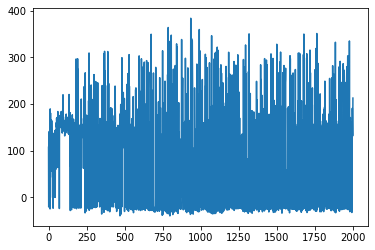

In [9]:
plt.plot(Reward_train)